<a href="https://colab.research.google.com/github/Khlebovich-Alexandra/horoscope_generator/blob/master/text_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text generation with an RNN

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM 
from tensorflow.keras.utils import to_categorical

import numpy as np
import pandas as pd
import itertools
import os
import re
import time
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [0]:
posts = pd.read_csv('https://raw.githubusercontent.com/Khlebovich-Alexandra/horoscope_generator/master/Data/final_posts.csv', index_col=0)

In [0]:
posts

,text,length,date,type,index in posts,domain,index_before_concat
0,сегодня вы можете почувствовать незащищенность...,339,11 декабря,business,0,ribyhoroscop,0
1,вам звёзды рекомендуют сегодня больше работать...,303,11 декабря,love,0,ribyhoroscop,1
2,"если сегодня вы почувствуете робость, или, тог...",215,11 декабря,simple,0,ribyhoroscop,2
3,сегодня звезды рекомендуют вам заняться коррек...,278,10 декабря,business,1,ribyhoroscop,3
4,"сегодня ваш любимый человек признается в том, ...",273,10 декабря,love,1,ribyhoroscop,4
...,...,...,...,...,...,...,...
26957,"день преобразования космических энергий, получ...",544,2 марта,simple,2648,strelechoroscop,4575
26958,завтра - полон перемен для вас. поэтому строит...,256,1 марта,simple,2649,strelechoroscop,4576
26959,утром не мешкая приступайте к работе или завяз...,441,28 февраля,simple,2650,strelechoroscop,4577
26960,общительность и дружелюбие вас сегодня могут н...,453,27 февраля,simple,2651,strelechoroscop,4578


In [0]:
posts.drop(['date', 'type', 'index in posts', 'domain', 'index_before_concat'], axis=1, inplace=True)

In [0]:
posts.drop(np.argmax(posts.length), inplace=True)

In [0]:
def add_spaces(x):
    literals = ',.?!;:()'
    for literal in literals:
        if literal in x:
            x = x.replace(literal, ' ' + literal + ' ')
            
    pattern_bad_spaces_1 = re.compile(r'(^ +)|( +$)')
    pattern_bad_spaces_2 = re.compile(r'(  +)|(\t)')
    x = re.sub(pattern_bad_spaces_1, '', x)
    x = re.sub(pattern_bad_spaces_2, ' ', x)
    return x

In [0]:
def split(x):
    res = re.split(re.compile(r'[ ]+'), x.lower())
    while '' in res:
        res.remove('')
    return res

In [0]:
def create_vocab(texts):
    texts = pd.Series(texts)
    texts = texts.map(add_spaces)
    texts = texts.map(split)
    word_index = {}
    word_index["<Заполнитель>"] = 0
    word_index["<Начало последовательности>"] = 1
    word_index["<Не используется>"] = 2
    word_index["<Неизвестное слово>"] = 3
    ind = 4
    for text in texts:
        for word in text:
            if not (word in word_index):
                word_index[word] = ind
                ind += 1
    return word_index

In [0]:
def word_to_int(word):
    if word in word_index:
        return word_index[word]
    return 3

In [0]:
def get_word_by_index(index):
    for word, value in word_index.items():
        if index == value:
            return word
    return ''

In [0]:
def create_dataset(text):
    text = add_spaces(text)
    text = split(text)
    text = list(map(word_to_int, text))
    return text

In [0]:
word_index = create_vocab(posts.text)

In [0]:
word_index['.']

14

In [0]:
len(word_index)

47923

In [0]:
print(create_dataset(posts.text[0]))

[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 9, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 14, 28, 29, 30, 31, 32, 33, 19, 34, 35, 36, 37, 19, 38, 39, 40, 41, 42, 43, 44, 14, 45, 46, 47, 25, 48, 49, 14]


In [0]:
posts.text = posts.text.map(create_dataset)

In [0]:
posts.length = posts.text.map(len)

Save DataFrame and vocabluary

In [0]:
posts.to_csv('posts_word_to_int.csv')

In [0]:
import json

with open('vocab.json', 'w') as fp:
    json.dump(word_index, fp)

Padding seq

In [0]:
def get_list_of_ints(x):
    if isinstance(x, str):
        x = x.strip('][').split(', ')
    return list(map(int, x))

In [0]:
posts = pd.read_csv('posts_word_to_int.csv', index_col=0)
posts.text = posts.text.map(get_list_of_ints)
posts

,text,length
0,"[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...",53
1,"[50, 51, 52, 4, 53, 54, 14, 55, 56, 57, 58, 59...",49
2,"[89, 4, 5, 90, 91, 19, 56, 19, 92, 93, 94, 19,...",40
3,"[4, 109, 52, 50, 110, 111, 56, 112, 113, 114, ...",46
4,"[4, 136, 137, 138, 139, 11, 140, 19, 20, 141, ...",46
...,...,...
26957,"[199, 7429, 7906, 19954, 19, 8101, 20213, 8982...",81
26958,"[3016, 81, 2294, 3598, 47, 25, 14, 302, 6957, ...",40
26959,"[8803, 121, 47918, 13480, 71, 535, 56, 35595, ...",63
26960,"[8673, 9, 5898, 25, 4, 702, 23496, 87, 19815, ...",68


In [0]:
posts.describe()

,length
count,26961.000000
mean,50.237640
std,15.919764
min,4.000000
25%,40.000000
50%,48.000000
75%,58.000000
max,129.000000


In [0]:
maxlen = 75

In [0]:
texts = pad_sequences(posts.text, maxlen, padding='post')
texts = tf.data.Dataset.from_tensor_slices(texts)

In [0]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = texts.map(split_input_target)

In [0]:
dataset.take(1)

<TakeDataset shapes: ((74,), (74,)), types: (tf.int32, tf.int32)>

In [0]:
# Batch size
BATCH_SIZE = 128

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((128, 74), (128, 74)), types: (tf.int32, tf.int32)>

In [0]:
# define model
vocab_size = len(word_index)
embedding_dim = 256
rnn_units = 1024

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[BATCH_SIZE, None]),
    tf.keras.layers.GRU(units=512,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.GRU(units=2048,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dropout(rate=0.05),
    tf.keras.layers.Dense(vocab_size)
  ])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (128, None, 256)          12268288  
_________________________________________________________________
gru_4 (GRU)                  (128, None, 512)          1182720   
_________________________________________________________________
dense_4 (Dense)              (128, None, 512)          262656    
_________________________________________________________________
gru_5 (GRU)                  (128, None, 2048)         15740928  
_________________________________________________________________
dropout_2 (Dropout)          (128, None, 2048)         0         
_________________________________________________________________
dense_5 (Dense)              (128, None, 47923)        98194227  
Total params: 127,648,819
Trainable params: 127,648,819
Non-trainable params: 0
________________________________________

In [0]:
 for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(128, 74, 47923) # (batch_size, sequence_length, vocab_size)


In [0]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [0]:
sampled_indices

array([32341, 36910,  4117, 17544, 47576, 20505, 22704, 28528, 19842,
       25116, 15106,  8816, 25980, 45988, 14773, 44644,  9335, 46645,
       14880,  2355, 29507, 27882, 44500, 44257, 20250, 12917,  5478,
        6511, 43324, 22321, 25066, 37438, 44108, 31130, 15659, 34369,
       16448,  6506, 38436, 38771, 24729, 11710, 25678, 40234,  3327,
       11807,   245, 34399, 29662,  4572, 16744, 24195, 22114, 12399,
       29286, 31436, 12513, 42869,  7388, 37465,  4706, 38212, 24216,
       24512, 28350, 43241,  3414, 43775, 15230,  3914, 45592,  2651,
       23099, 20657])

Decode these to see the text predicted by this untrained model:

In [0]:
print("Input: \n", repr(" ".join([get_word_by_index(i) for i in input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr(" ".join([get_word_by_index(i) for i in sampled_indices])))

Input: 
 'если у вас есть какой-то повод для ревности , обсудите с вашим любимым человеком создавшуюся ситуацию . пусть он честно вам ответит , есть ли у вас конкурент , а у него - претендент на ваше место . только прежде чем начать расспросы , подуэтот месяцте : а точно ли вы хотите знать правду ? <Заполнитель> <Заполнитель> <Заполнитель> <Заполнитель> <Заполнитель> <Заполнитель> <Заполнитель> <Заполнитель> <Заполнитель> <Заполнитель> <Заполнитель> <Заполнитель> <Заполнитель> <Заполнитель> <Заполнитель> <Заполнитель> <Заполнитель> <Заполнитель> <Заполнитель>'

Next Char Predictions: 
 'выетостроение мрачны родителями незнакомцам меняющимся деловитым зажгутся разбудить подвижным усиливаться возникновения поводом рекомендацией альтернативное приблизить светлую вялым сувениров вещественные коллективе вдумчивого инструктаж уставшие притягивая неформальные напряжения посещаете хищниками кричать предстоящая прерванные удобств вершина тёмной страдаете вектор заботах экзотариум привносит инст

## Train the model

The standard `tf.keras.losses.sparse_categorical_crossentropy` loss function works in this case because it is applied across the last dimension of the predictions.

Because our model returns logits, we need to set the `from_logits` flag.


In [0]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (128, 74, 47923)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       10.77728


Configure the training procedure using the `tf.keras.Model.compile` method. We'll use `tf.keras.optimizers.Adam` with default arguments and the loss function.

In [0]:
model.compile(optimizer='adam', loss=loss)

### Configure checkpoints

Use a `tf.keras.callbacks.ModelCheckpoint` to ensure that checkpoints are saved during training:

In [0]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True,
    verbose=0)

checkpoint_callback_1=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    period=10,
    save_weights_only=True,
    verbose=0)

### Execute the training

To keep training time reasonable, use 10 epochs to train the model. In Colab, set the runtime to GPU for faster training.

In [0]:
EPOCHS=100

In [0]:
history = model.fit(dataset, 
                    epochs=EPOCHS,
                    callbacks=[checkpoint_callback_1])

Train for 210 steps
Epoch 1/100
210/210 [==============================] - 209s 995ms/step - loss: 4.7133
Epoch 2/100
210/210 [==============================] - 209s 995ms/step - loss: 4.6340
Epoch 3/100
210/210 [==============================] - 209s 995ms/step - loss: 4.4611
Epoch 4/100
210/210 [==============================] - 209s 996ms/step - loss: 4.2766
Epoch 5/100
210/210 [==============================] - 209s 995ms/step - loss: 4.1377
Epoch 6/100
210/210 [==============================] - 209s 996ms/step - loss: 4.0307
Epoch 7/100
210/210 [==============================] - 209s 996ms/step - loss: 3.9412
Epoch 8/100
210/210 [==============================] - 209s 997ms/step - loss: 3.8567
Epoch 9/100
210/210 [==============================] - 209s 996ms/step - loss: 3.7880
Epoch 10/100
210/210 [==============================] - 219s 1s/step - loss: 3.7240
Epoch 11/100
210/210 [==============================] - 210s 999ms/step - loss: 3.6637
Epoch 12/100
210/210 [=============

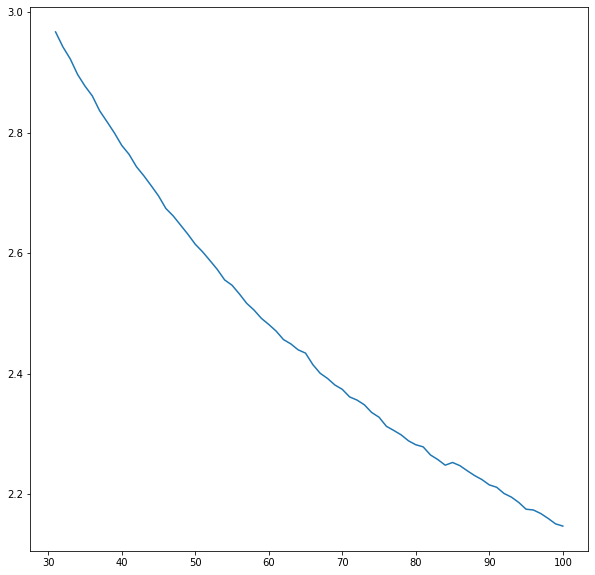

In [0]:
plt.figure(figsize=(10, 10))
x = list(range(1, 101))
plt.plot(x[30:], history.history.get('loss')[30:])

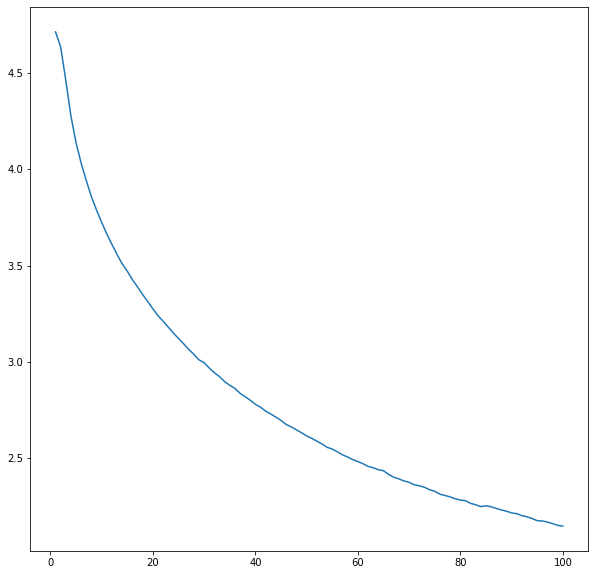

In [0]:
plt.figure(figsize=(10, 10))
x = list(range(1, 101))
plt.plot(x, history.history.get('loss'))

In [0]:
model.load_weights('./training_checkpoints/ckpt_100')
model_json = model.to_json()
json_file = open('posts_model.json_100', 'w')
json_file.write(model_json)
json_file.close()
model.save_weights('posts_model_100.h5')

## Generate text

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[1, None]),
    tf.keras.layers.GRU(units=512,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.GRU(units=2048,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dropout(rate=0.05),
    tf.keras.layers.Dense(vocab_size)
  ])

model.load_weights('posts_model_100.h5')

model.build(tf.TensorShape([1, None]))

In [0]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (1, None, 256)            12268288  
_________________________________________________________________
gru_6 (GRU)                  (1, None, 512)            1182720   
_________________________________________________________________
dense_6 (Dense)              (1, None, 512)            262656    
_________________________________________________________________
gru_7 (GRU)                  (1, None, 2048)           15740928  
_________________________________________________________________
dropout_3 (Dropout)          (1, None, 2048)           0         
_________________________________________________________________
dense_7 (Dense)              (1, None, 47923)          98194227  
Total params: 127,648,819
Trainable params: 127,648,819
Non-trainable params: 0
________________________________________

In [0]:
def generate_text(model, start_string, num_of_words, temp):
  # Evaluation step (generating text using the learned model)

  # Converting our start string to numbers (vectorizing)
  text = start_string

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = temp

  # Here batch size == 1
  model.reset_states()
  for i in range(num_of_words):
      input_eval = create_dataset(start_string)
      input_eval = pad_sequences([input_eval], maxlen - 1, padding='post')

      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a categorical distribution to predict the word returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # We pass the predicted word as the next input to the model
      # along with the previous hidden state
      new_word = get_word_by_index(predicted_id)
      text = text + ' ' + new_word

  return text

In [0]:
generate_text(model, 'сегодня вам ', 10, 4.5)

'сегодня вам  другую осуществить эмоции вопросами время очередной очень времени вечерние удачными'

In [0]:
for i in range(100):
    print(generate_text(model, 'сегодня', 10, 10))

сегодня мелкий отмалчиваться подумает потребительское уладятся родителям-тельцам исчезнвыия организме вызывающие потерять
сегодня наставничество минуте возникшую плюсов недостатков переговорах реальный собака улучшает прямом
сегодня прекраснее помех хорошая пакетиков женские беседы подарок некачественный пешая трава
сегодня мешали разумного сомневайтесь немножко далекое ка экстраординарного задают спиртными такие
сегодня трудовую конфликтная сокрвыными накопилась заманчивое подстраиваться приход сварливым четких сбор
сегодня внешним срочные насладитесь подобрались просьбах цыпочках перспективные расстался тонкой оздоровительным
сегодня проделанной самолёт довольно-таки включает побалует диагнозы по-другому приветствуеэтого активные жесткого
сегодня вероятны самобытность «звездного неправдоподобные вам-мужчинам разумное согласуются осторожность стремительно пресным
сегодня принципа удачное пригласит шерсти сделанные «вьёт материализует сильнодействующих терпимость действенных
сегодня ув

In [0]:
generate_text(model, 'сегодня вам ', 10, 28)

'сегодня вам  повторение веществам «распустятся» следствием сонастройки казалось импульс извлеченные проявлений строительные'

Save model

In [0]:
!ls

posts_model_100.h5    posts_word_to_int.csv  training_checkpoints
posts_model.json_100  sample_data	     vocab.json


In [0]:
model_json = model.to_json()
json_file = open('posts_model.json', 'w')
json_file.write(model_json)
json_file.close()
model.save_weights('posts_model.h5')

In [0]:
!ls

posts_model_100.h5  posts_model.json_100   training_checkpoints
posts_model.h5	    posts_word_to_int.csv  vocab.json
posts_model.json    sample_data


# Generate by symbols

In [0]:
posts = pd.read_csv('https://raw.githubusercontent.com/Khlebovich-Alexandra/horoscope_generator/master/Data/final_posts.csv', index_col=0)

In [0]:
text = posts.text
text = '\n'.join(text)

print ('Length of text: {} characters'.format(len(text)))

In [0]:
# Take a look at the first 250 characters in text
print(text[:250])

In [0]:
vocab = sorted(set(text))
print ('{} unique characters'.format(len(vocab)))

In [0]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

In [0]:
# The maximum length sentence we want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
    print(idx2char[i.numpy()])

In [0]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
    print(repr(''.join(idx2char[item.numpy()])))

In [0]:
dataset = sequences.map(split_input_target)

In [0]:
for input_example, target_example in  dataset.take(1):
    print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
    print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))

In [0]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

In [0]:
# Batch size
BATCH_SIZE = 128

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

In [0]:
vocab_size = len(vocab)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[BATCH_SIZE, None]),
    tf.keras.layers.GRU(units=512,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.GRU(units=2048,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dropout(rate=0.05),
    tf.keras.layers.Dense(vocab_size)
  ])

print(model.summary())

In [0]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

In [0]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [0]:
sampled_indices

array([38353, 40910, 46998, 13216, 41677,  5467, 47392, 17784, 30947,
       44583, 18622, 46111, 13577, 38166, 28521,  6094, 14596, 23554,
        9833,  7827, 42237, 42837, 34083, 37533,  5045, 16680,   671,
       46811, 19868, 13827, 42040, 22782, 20834, 42382, 10830, 22370,
       38676, 14987, 33973, 21318, 35449, 11012,  4289, 14062, 12111,
       44289, 13324,   547, 44072, 40249, 40466, 36392, 20999, 18244,
       39340, 33658, 42328,  3867, 29015, 31691, 40928,  4106, 29458,
       43783, 34386, 42441, 13062, 34976, 31465, 32042, 34050, 32508,
       17978,  3301])

In [0]:
print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices ])))

NameError: ignored

## Train the model

In [0]:
model.compile(optimizer='adam', loss=loss)

In [0]:
checkpoint_callback_2=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix+'_symb',
    period=10,
    save_weights_only=True,
    verbose=0)

In [0]:
history1 = model.fit(dataset,
                     epochs=100,
                     callbacks=[checkpoint_callback_2]))

SyntaxError: ignored

In [0]:
model_json = model.to_json()
json_file = open('posts_model_symbols.json', 'w')
json_file.write(model_json)
json_file.close()
model.save_weights('posts_model_symbols.h5')

## Generate text

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[1, None]),
    tf.keras.layers.GRU(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])

model.load_weights('posts_model_symbols.h5')

model.build(tf.TensorShape([1, None]))

In [0]:
model.summary()

In [0]:
def generate_text_symbols(model, start_string):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
  num_generate = 3000

  # Converting our start string to numbers (vectorizing)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = 1.0

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a categorical distribution to predict the word returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # We pass the predicted word as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [0]:
print(generate_text_symbols(model, start_string=u"сегодня "))

In [0]:
print(generate_text_symbols(model, start_string=u"сегодня "))

In [0]:
print(generate_text_symbols(model, start_string=u"сегодня вам"))

In [0]:
print(generate_text_symbols(model, start_string=u"сегодня "))

In [0]:
print(generate_text_symbols(model, start_string=u"сегодня "))

In [0]:
print(generate_text_symbols(model, start_string=u"сегодня "))

In [0]:
print(generate_text_symbols(model, start_string=u"сегодня "))

In [0]:
print(generate_text_symbols(model, start_string=u"вам "))

In [0]:
print(generate_text_symbols(model, start_string=u"вас "))

In [0]:
print(generate_text_symbols(model, start_string=u"вы "))

In [0]:
print(generate_text_symbols(model, start_string=u"сегодня "))

In [0]:
model_json = model.to_json()
json_file = open('posts_model.json', 'w')
json_file.write(model_json)
json_file.close()
model.save_weights('posts_model.h5')